# Project : Predicting temperature around nuclear waste cannister

## Neural Network

Frank Djidingar Monbe 316435 and Sophie Tiberghien 282240

<hr style="clear:both">

This notebook is part of a machine learning project. The goal is to predict temperature of sensor around a nuclear waste cannister for different times. More information is available in the ReadMe file.

The purpose of this notebook is to apply the neural network model.

<hr style="clear:both">

# 1 - Imports

In [1]:
# import librairies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# import machine learning packages

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



# 2 - Data recuperation

In [2]:
# recuperate the complete data set
X_train = pd.read_csv('X_train.csv') 
X_test = pd.read_csv('X_test.csv')

# convert into numpy arrays
X_train= X_train.to_numpy()
X_test = X_test.to_numpy()

print('\nTrain set shape:')
print(f'X: {X_train.shape} ')

print('\nTest set shape:')
print(f'X: {X_test.shape} ')


Train set shape:
X: (28704, 8) 

Test set shape:
X: (4640, 7) 


# 3 - Standardization

In [3]:
# Compute the mean and standard deviation for each feature of the training set

X_train_temp = X_train[:,3]
X_train_without_temp = np.delete(X_train,3,axis=1)

mean = X_train_without_temp.mean(axis=0)
std = X_train_without_temp.std(axis=0)

# Implement the normalize function
def normalize(X: np.ndarray, mean: np.ndarray, std: np.ndarray):
    X_normalized = (X - mean) / std
    return X_normalized

# Normalize features of the data and test set using the mean and std of the training set features
X_train_normalized = normalize(X_train_without_temp, mean, std)
X_test_normalized = normalize(X_test, mean, std)

# 4 - Data transformation

In [4]:
# Convert the numpy tensor to a PyTorch tensor
train_tensor_normalized = torch.from_numpy(X_train_normalized).float()
test_tensor_normalized = torch.from_numpy(X_test_normalized).float()
train_targets = torch.from_numpy(X_train_temp).float()  

# 5 - Neural network

In [5]:
torch.manual_seed(1234)  # In order to have complety reproducible results 

class TemperaturePredictionNet(nn.Module):
    def __init__(self, input_size):
        super(TemperaturePredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


# 6 - Pytorch datasets for training, test and validation

In [6]:
train_features = train_tensor_normalized
train_targets = train_targets

# Converting Tensors to PyTorch Datasets
train_dataset = TensorDataset(train_features, train_targets)
test_features = test_tensor_normalized
test_dataset = TensorDataset(test_features)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_normalized, train_targets, test_size=0.2, random_state=1234)

# Convert the numpy arrays to PyTorch tensors
train_features = torch.from_numpy(X_train).float()
val_features = torch.from_numpy(X_val).float()


batch_size = 32


# Create the training dataset and data loader
train_dataset = TensorDataset(train_features, y_train)  # Use y_train instead of train_targets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the validation dataset and data loader
val_dataset = TensorDataset(val_features, y_val)  # Use y_val instead of val_targets
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7 - Loss &amp; optimizer

In [7]:
input_size = train_features.shape[1]
net = TemperaturePredictionNet(input_size)

criterion = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0)

# 8 - Model training

In [8]:
# Creating the learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Training loop
num_epochs = 300
train_losses = []  # List to store training losses
val_losses = []  # List to store validation losses
for epoch in range(num_epochs):
    # Training
    net.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_size/len(train_dataset)
    train_losses.append(running_loss)  # Add training loss to the list

    # Validation
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = net(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            val_loss += loss.item() * batch_size/len(val_dataset)
        val_losses.append(val_loss)  # Add validation loss to the list
        
    # Update the learning rate scheduler
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss}, Validation Loss: {val_loss}")


Epoch 1/300, Training Loss: 3.361732103982124, Validation Loss: 1.3366817918892744
Epoch 2/300, Training Loss: 1.2342046661170962, Validation Loss: 1.1208341147006322
Epoch 3/300, Training Loss: 0.9153593145834871, Validation Loss: 0.771699142422832
Epoch 4/300, Training Loss: 0.8392303131891603, Validation Loss: 0.8424943808665405
Epoch 5/300, Training Loss: 0.7206526071732606, Validation Loss: 0.5642150281883871
Epoch 6/300, Training Loss: 0.624736648089108, Validation Loss: 0.6360827900976735
Epoch 7/300, Training Loss: 0.6134741006970883, Validation Loss: 0.5762880478476715
Epoch 8/300, Training Loss: 0.6082745167777462, Validation Loss: 0.5022554211532628
Epoch 9/300, Training Loss: 0.5625096290663802, Validation Loss: 0.6258251409126973
Epoch 10/300, Training Loss: 0.5423034422853309, Validation Loss: 0.6591045954069221
Epoch 11/300, Training Loss: 0.4917137406561031, Validation Loss: 0.7105309751012602
Epoch 12/300, Training Loss: 0.5058858680251647, Validation Loss: 0.478334908

# 9 - Training loss and validation loss visualization 

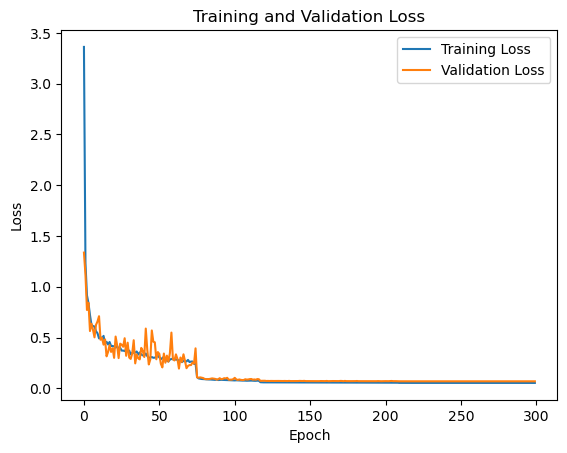

In [9]:
# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 10 - Predictions 

In [10]:
# Predictions
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False )
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        outputs = net(inputs[0])
        predictions.extend(outputs.squeeze().tolist())

predictions = np.array(predictions)
print(predictions)
predictions = pd.DataFrame(predictions)

[17.24313164 17.29637909 17.35013199 ... 42.30164337 42.89477158
 43.19836426]


## Predictions reshappe in format submission

In [11]:
chunk_size = 32
num_chunks = (len(predictions) + chunk_size - 1) // chunk_size  # Round up
test_preds_clean_list = []  # List to hold chunks

for i in range(num_chunks):
    chunk_start = i * chunk_size
    chunk_end = min((i + 1) * chunk_size, len(predictions))
    chunk = predictions[chunk_start:chunk_end]
    chunk = np.reshape(chunk, (-1, 1))  # Reshape to have second dimension
    test_preds_clean_list.append(chunk)

test_preds_clean = np.concatenate(test_preds_clean_list, axis=1)
print(test_preds_clean)

# Create a new row with the desired values
new_row = np.array([" ","N_901", "N_902", "N_903", "N_904", "N_905", "N_906", "N_907", "N_908", "N_910", "N_911", "N_912", "N_913", "N_914", "N_915", "N_916", "N_917", "N_918", "N_919", "N_920", "N_921", "N_922", "N_923", "N_924", "N_925", "N_926", "N_927", "N_928", "N_929", "N_930", "N_931", "N_932", "N_933", "N_934", "N_935", "N_936", "N_937", "N_938", "N_939", "N_940", "N_941", "N_942", "N_943", "N_944", "N_945", "N_946", "N_947", "N_948", "N_949", "N_950", "N_951", "N_952", "N_953", "N_954", "N_955", "N_956", "N_957", "N_958", "N_959", "N_960", "N_961", "N_962", "N_963", "N_964", "N_965", "N_966", "N_967", "N_968", "N_969", "N_970", "N_971", "N_972", "N_973", "N_974", "N_975", "N_976", "N_977", "N_978", "N_979", "N_980", "N_981", "N_982", "N_983", "N_984", "N_985", "N_986", "N_987", "N_988", "N_989", "N_990", "N_991", "N_992", "N_993", "N_994", "N_995", "N_996", "N_997", "N_998", "N_999", "N_1000", "N_1001", "N_1002", "N_1003", "N_1004", "N_1005", "N_1006", "N_1007", "N_1008", "N_1009", "N_1010", "N_1011", "N_1012", "N_1013", "N_1014", "N_1015", "N_1016", "N_1017", "N_1018", "N_1019", "N_1020", "N_1021", "N_1022", "N_1023", "N_1024", "N_1025", "N_1026", "N_1027", "N_1028", "N_1029", "N_1030", "N_1031", "N_1032", "N_1033", "N_1034", "N_1035", "N_1036", "N_1037", "N_1038", "N_1039", "N_1040", "N_1041", "N_1042", "N_1043", "N_1044", "N_1045", "N_1046"])

new_col = np.array(["1554", "1556", "1558", "1560", "1563", "1567", "1572", "1578", "1585", "1595", "1606", "1621", "1639", "1662", "1690", "1726", "1770", "1826", "1895", "1982", "2090", "2226", "2395", "2607", "2871", "3202", "3616", "4133", "4779", "5587", "6597", "7028"])

data = np.column_stack((new_col, test_preds_clean))
data = np.vstack((new_row,data))

np.savetxt('x_pred.csv', data, delimiter=',', fmt='%s')

[[17.24313164 17.2057724  18.05584335 ... 17.20228195 17.39519882
  17.51554489]
 [17.29637909 17.21011543 18.15457153 ... 17.20730591 17.39945984
  17.52291107]
 [17.35013199 17.21446037 18.27073479 ... 17.21232986 17.40742111
  17.53027534]
 ...
 [49.39025879 39.34712982 52.44841766 ... 36.40121078 40.46835709
  42.30164337]
 [50.1414566  39.96056747 53.02407837 ... 37.06378937 41.2115097
  42.89477158]
 [50.39393234 40.19416809 53.1712265  ... 37.29310608 41.29037857
  43.19836426]]


## Predictions visualization 

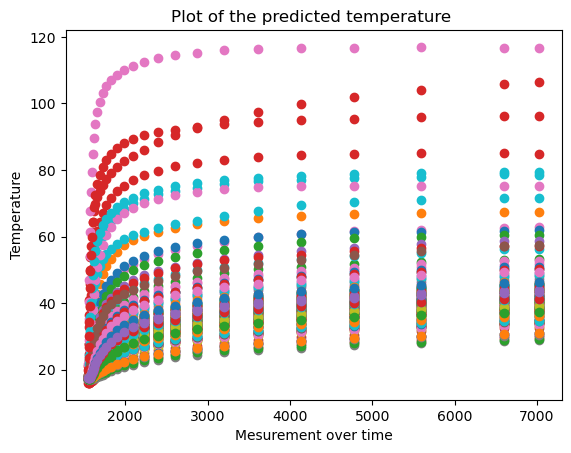

In [23]:
predicted_temp = pd.read_csv('x_pred.csv')
#Visualizing all the temperature variation for all the point 
x_data = predicted_temp.iloc[:, 0]
y_data = predicted_temp.iloc[:, 1:]  # we want all the columns but the first
for i in range(y_data.shape[1]):
    plt.scatter(x_data, y_data.iloc[:, i], label=f"Column {i+1}")
plt.xlabel("Mesurement over time")
plt.ylabel("Temperature")
plt.title('Plot of the predicted temperature ')
plt.show()

## 11 - Tackling point N_955

In [24]:
# Import training data
coordinates_train = pd.read_csv("data/TrainingData/Coordinates_Training.csv")
temperature_train_clean = pd.read_csv("temperature_train_clean.csv")

# Import testing data
coordinates_test = pd.read_csv("data/TestDataStudents/Coordinates_Test.csv")

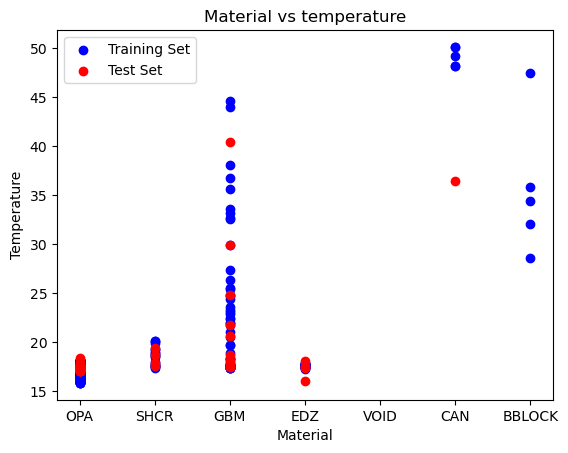

In [25]:
# Plotting training set data
x_mat_1 = coordinates_train.iloc[:, 3]
y_mat_1 = temperature_train_clean.iloc[3, 1:]  # we want all the columns but the first because it is the times

plt.scatter(x_mat_1, y_mat_1, color='blue', label='Training Set')

# Plotting test set data
x_mat_2 = coordinates_test.iloc[:, 3]
y_mat_2 = predicted_temp.iloc[3, 1:]  # we want all the columns but the first because it is the times

plt.scatter(x_mat_2, y_mat_2, color='red', label='Test Set')

plt.xlabel("Material")
plt.ylabel("Temperature")
plt.title('Material vs temperature')
plt.legend()
plt.show()

We can clearly see that the can material is not predicted well !!!, the temperature of this sensor (N_955) should be much higher. 
To tackle this problem we can look for sensor of the train set with the can material. After investigation, there is several sensor of CAN material, however some of them were deleted because of the missing values for humidity and pressure, so we only have 3 sensor that we can use. we are taking the mean of these three sensors for each time and putting it for sensor N_955

In [26]:
temp_clean = pd.read_csv('temperature_train_clean.csv')
selected_columns = ['N_854', 'N_880', 'N_899'] 
can_sensor= temp_clean[selected_columns]

In [27]:
mean_can = can_sensor.mean(axis=1)
mean_can_list = mean_can.tolist()

In [28]:
predicted_temp = pd.read_csv('x_pred.csv')
column_name = 'N_955'
for i, row in predicted_temp.iterrows():
    predicted_temp.at[i, column_name] = mean_can_list[i]

predicted_temp.to_csv('predictions_nn.csv', index=False)

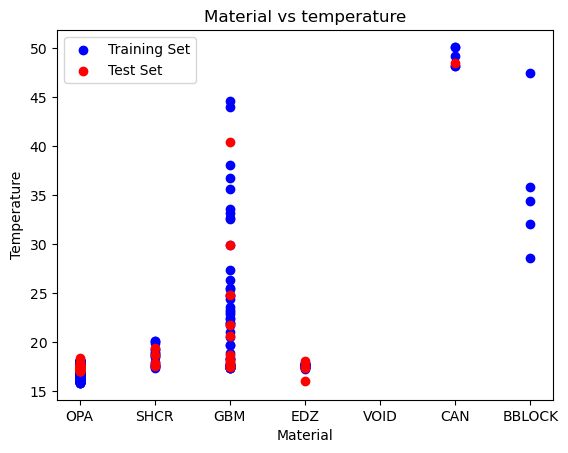

In [29]:
# Plotting training set data
x_hum_train = coordinates_train.iloc[:, 3]
y_hum_train = temperature_train_clean.iloc[3, 1:]  # we want all the columns but the first because it is the times

plt.scatter(x_hum_train, y_hum_train, color='blue', label='Training Set')

# Plotting test set data
x_hum_test = coordinates_test.iloc[:, 3]

y_hum_test = predicted_temp.iloc[3, 1:]  # we want all the columns but the first because it is the times
plt.scatter(x_hum_test, y_hum_test, color='red', label='Test Set')

plt.xlabel("Material")
plt.ylabel("Temperature")
plt.title('Material vs temperature')
plt.legend()
plt.show()

This is clearly better.

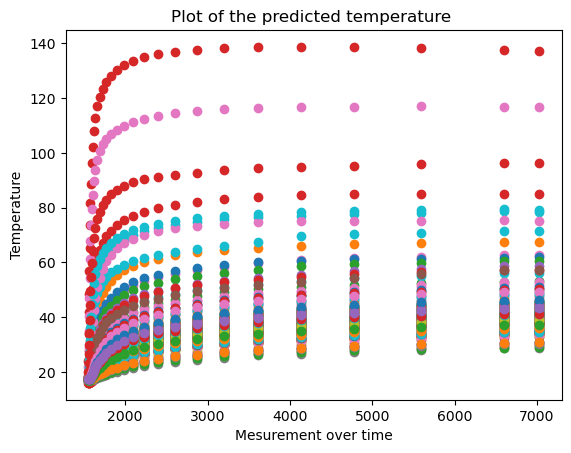

In [30]:
predicted_temp_modif = pd.read_csv('predictions_nn.csv')
#Visualizing all the temperature variation for all the point 
x_data = predicted_temp_modif.iloc[:, 0]
y_data = predicted_temp_modif.iloc[:, 1:]  # we want all the columns but the first
for i in range(y_data.shape[1]):
    plt.scatter(x_data, y_data.iloc[:, i], label=f"Column {i+1}")
plt.xlabel("Mesurement over time")
plt.ylabel("Temperature")
plt.title('Plot of the predicted temperature ')
plt.show()

## 12 - Final plots and conclusion

Now that we have modify, the temperature for sensor N_955 we can plot the relation of temperature with different features and compararing the training set and testing set

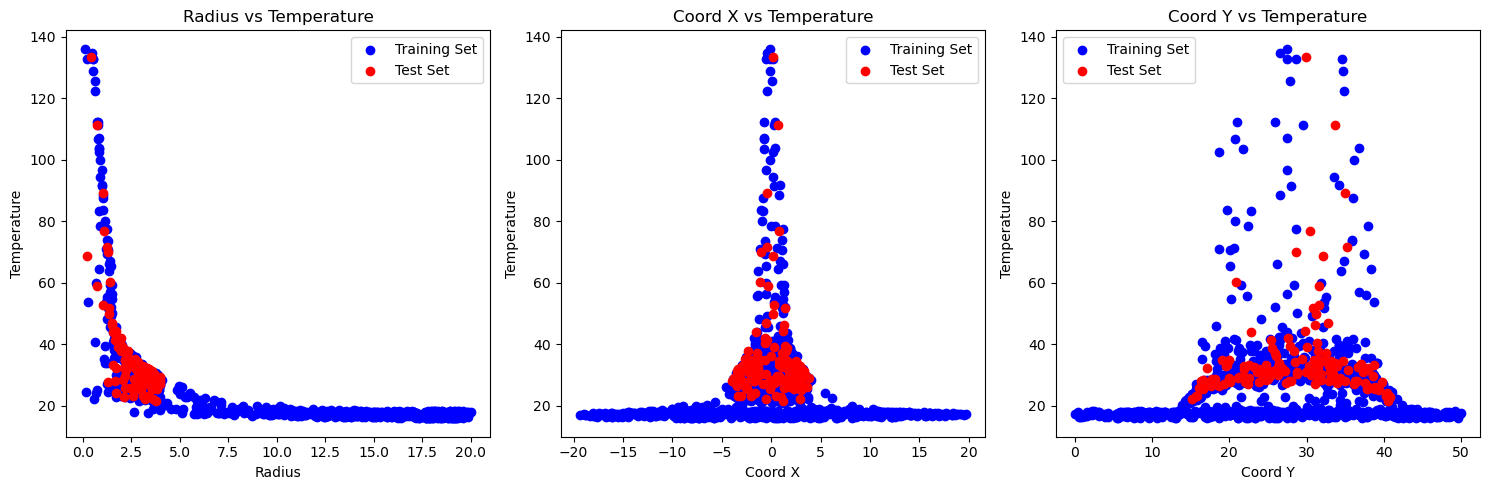

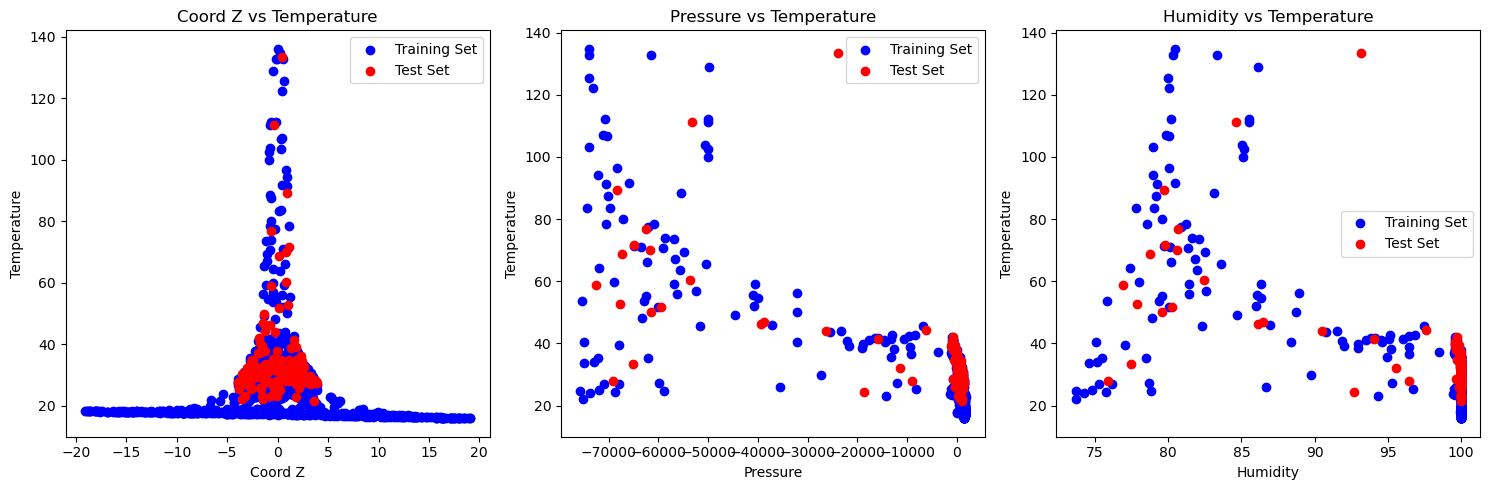

In [31]:
predicted_temp = pd.read_csv('predictions_nn.csv')

# Import training data

coordinates_train = pd.read_csv("data/TrainingData/Coordinates_Training.csv")
humidity_train = pd.read_csv("data/TrainingData/Training_data_humidity.csv")
pressure_train = pd.read_csv("data/TrainingData/Training_data_pressure.csv")
temperature_train_clean = pd.read_csv("temperature_train_clean.csv")

# Import testing data

coordinates_test = pd.read_csv("data/TestDataStudents/Coordinates_Test.csv")
humidity_test = pd.read_csv("data/TestDataStudents/Test_Time_humidity.csv")
pressure_test = pd.read_csv("data/TestDataStudents/Test_Time_pressure.csv")


# Importing training and testing data from the data prossesing notebook
train_data = pd.read_csv('merged_data_train.csv')
test_data = pd.read_csv('merged_data_test.csv')




x_rad_1 = coordinates_train.iloc[:, 7]
y_rad_1 = temperature_train_clean.iloc[20, 1:] 
x_rad_2 = coordinates_test.iloc[:, 7]
y_rad_2 = predicted_temp.iloc[20, 1:]
x_x_1 = coordinates_train.iloc[:, 4]
y_x_1 = temperature_train_clean.iloc[20, 1:]
x_x_2 = coordinates_test.iloc[:, 4]
y_x_2 = predicted_temp.iloc[20, 1:] 
x_y_1 = coordinates_train.iloc[:, 5]
y_y_1 = temperature_train_clean.iloc[20, 1:]
x_y_2 = coordinates_test.iloc[:, 5]
y_y_2 = predicted_temp.iloc[20, 1:]
x_z_1 = coordinates_train.iloc[:, 6]
y_z_1 = temperature_train_clean.iloc[20, 1:]
x_z_2 = coordinates_test.iloc[:, 6]
y_z_2 = predicted_temp.iloc[20, 1:]
x_pres_train = pressure_train.iloc[20, 1:]
y_pres_train = temperature_train_clean.iloc[20, 1:]
x_pres_test = pressure_test.iloc[20, 1:]
y_pres_test = predicted_temp.iloc[20, 1:]
x_hum_train = humidity_train.iloc[20, 1:]
y_hum_train = temperature_train_clean.iloc[20, 1:] 
x_hum_test = humidity_test.iloc[20, 1:]
y_hum_test = predicted_temp.iloc[20, 1:]




# First Row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting training set data - Radius vs Temperature
axes[0].scatter(x_rad_1, y_rad_1, color='blue', label='Training Set')
axes[0].scatter(x_rad_2, y_rad_2, color='red', label='Test Set')
axes[0].set_xlabel("Radius")
axes[0].set_ylabel("Temperature")
axes[0].set_title('Radius vs Temperature')
axes[0].legend()

# Plotting training set data - Coord X vs Temperature
axes[1].scatter(x_x_1, y_x_1, color='blue', label='Training Set')
axes[1].scatter(x_x_2, y_x_2, color='red', label='Test Set')
axes[1].set_xlabel("Coord X")
axes[1].set_ylabel("Temperature")
axes[1].set_title('Coord X vs Temperature')
axes[1].legend()

# Plotting training set data - Coord Y vs Temperature
axes[2].scatter(x_y_1, y_y_1, color='blue', label='Training Set')
axes[2].scatter(x_y_2, y_y_2, color='red', label='Test Set')
axes[2].set_xlabel("Coord Y")
axes[2].set_ylabel("Temperature")
axes[2].set_title('Coord Y vs Temperature')
axes[2].legend()

plt.tight_layout()
plt.show()

# Second Row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plotting training set data - Coord Z vs Temperature
axes[0].scatter(x_z_1, y_z_1, color='blue', label='Training Set')
axes[0].scatter(x_z_2, y_z_2, color='red', label='Test Set')
axes[0].set_xlabel("Coord Z")
axes[0].set_ylabel("Temperature")
axes[0].set_title('Coord Z vs Temperature')
axes[0].legend()

# Plotting training set data - Pressure vs Temperature
axes[1].scatter(x_pres_train, y_pres_train, color='blue', label='Training Set')
axes[1].scatter(x_pres_test, y_pres_test, color='red', label='Test Set')
axes[1].set_xlabel("Pressure")
axes[1].set_ylabel("Temperature")
axes[1].set_title('Pressure vs Temperature')
axes[1].legend()

# Plotting training set data - Humidity vs Temperature
axes[2].scatter(x_hum_train, y_hum_train, color='blue', label='Training Set')
axes[2].scatter(x_hum_test, y_hum_test, color='red', label='Test Set')
axes[2].set_xlabel("Humidity")
axes[2].set_ylabel("Temperature")
axes[2].set_title('Humidity vs Temperature')
axes[2].legend()

plt.tight_layout()
plt.show()

The final rating on Aicrowd was 0.4671 for L1 and 10.0108 for L2. Thanks to the modifying of sensor N_955 we were able to improve our L1 score from 0.4671 to 0.2263 and our L2 score from 10.0108 to 0.1748